In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def parse_test_time(t):
    try:
        t = str(t).strip()
        if pd.isna(t) or t.lower() == 'nan':
            return np.nan
        if '-' in t:
            days, rest = t.split('-')
            h, m, s = map(int, rest.split(':'))
            return int(days)*86400 + h*3600 + m*60 + s
        elif ':' in t:
            h, m, s = map(int, t.split(':'))
            return h*3600 + m*60 + s
        else:
            return float(t)
    except Exception as e:
        return np.nan



file1 = '/Users/kinshuokmunjal/Downloads/LR1865SZ_cycles201217_001_2.xlsx'
file2 = '/Users/kinshuokmunjal/Downloads/LR1865SZ_cycles201214_002_4.xlsx'
df1 = pd.read_excel(file1)
df2 = pd.read_excel(file2)

df1['Test_Time(s)'] = df1['Test_Time(s)'].apply(parse_test_time)
df2['Test_Time(s)'] = df2['Test_Time(s)'].apply(parse_test_time)


time_offset = df1['Test_Time(s)'].max() + 1
df2['Test_Time(s)'] += time_offset


df = pd.concat([df1, df2], ignore_index=True)

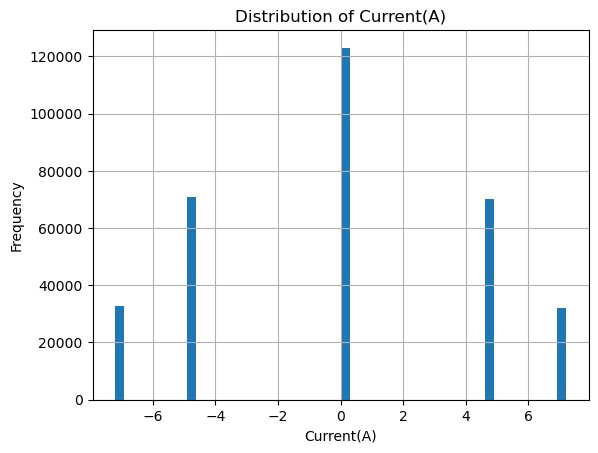

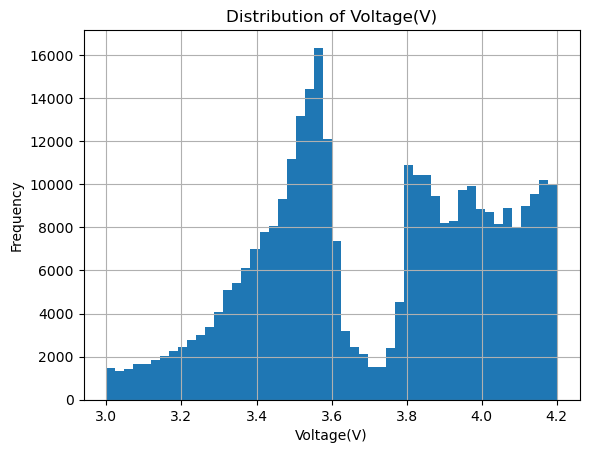

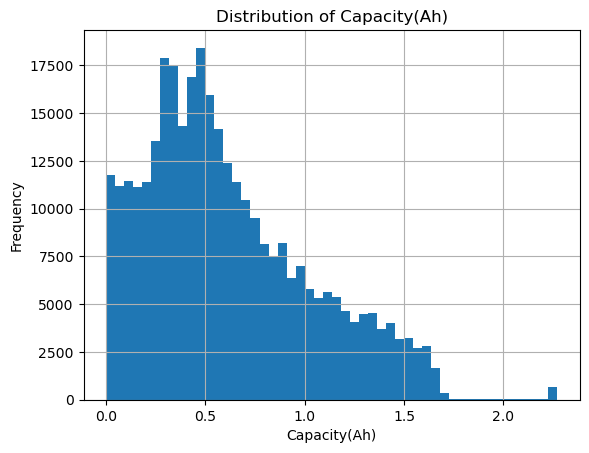

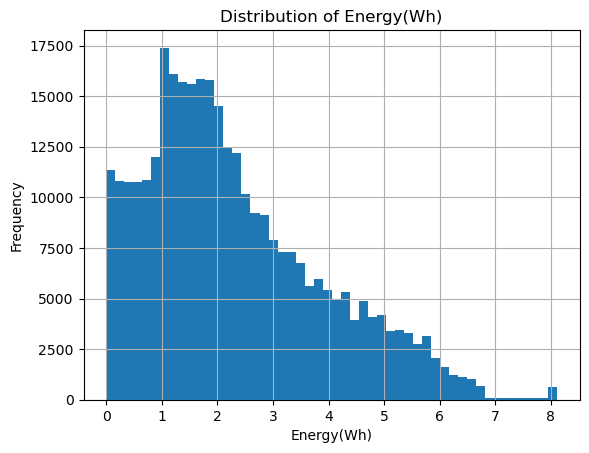

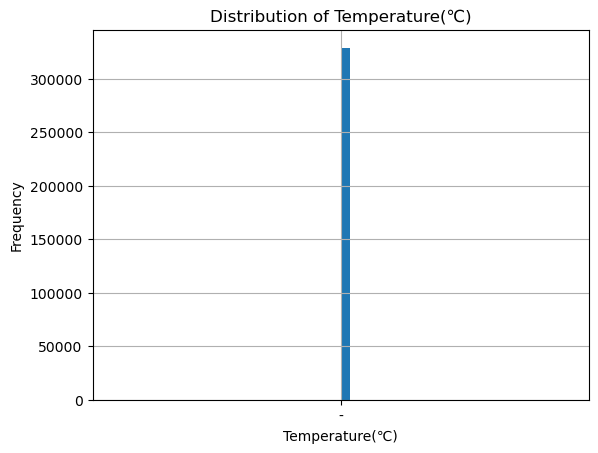

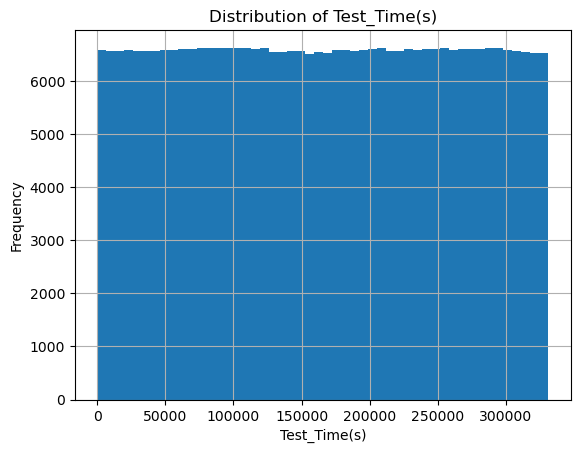

In [ ]:
variables = ['Current(A)', 'Voltage(V)', 'Capacity(Ah)', 'Energy(Wh)', 'Temperature(℃)']
for var in variables:
    plt.figure()
    df[var].hist(bins=50)
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')

Text(0, 0.5, 'Capacity (Ah)')

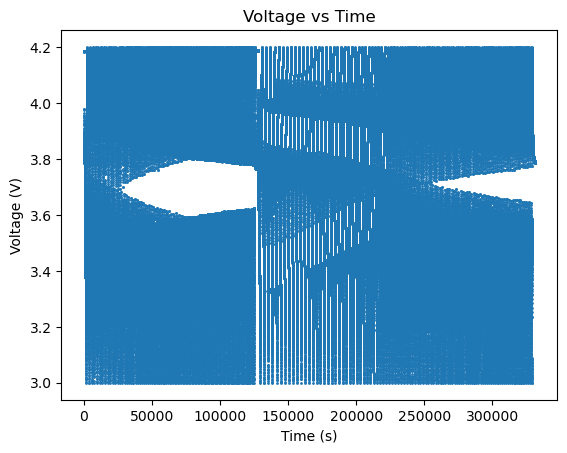

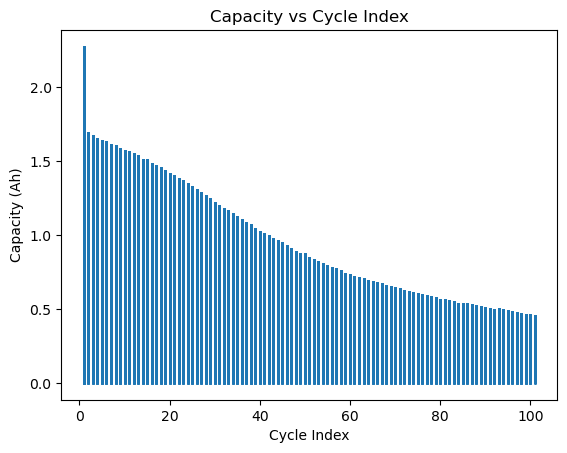

In [133]:
plt.figure()
plt.scatter(df['Test_Time(s)'], df['Voltage(V)'], s=1)
plt.title('Voltage vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')

plt.figure()
plt.scatter(df['Cycle_Index'], df['Capacity(Ah)'], s=1)
plt.title('Capacity vs Cycle Index')
plt.xlabel('Cycle Index')
plt.ylabel('Capacity (Ah)')

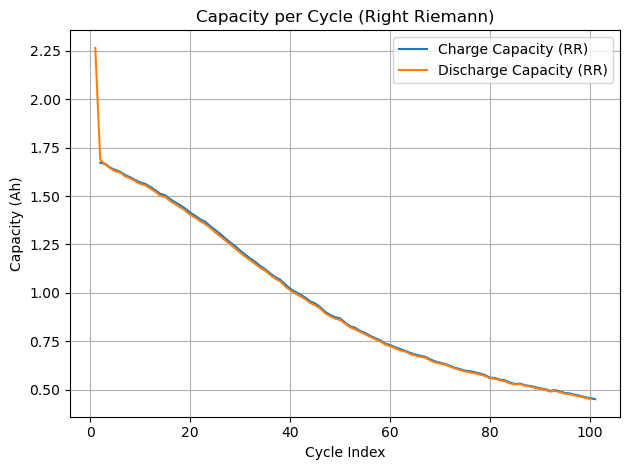

In [134]:

df = pd.concat([df1, df2], ignore_index=True)


charge_df_rr = df[df['Current(A)'] > 0].copy()
discharge_df_rr = df[df['Current(A)'] < 0].copy()


charge_df_rr = charge_df_rr.sort_values(['Cycle_Index', 'Test_Time(s)']).reset_index(drop=True)
discharge_df_rr = discharge_df_rr.sort_values(['Cycle_Index', 'Test_Time(s)']).reset_index(drop=True)


charge_df_rr['time_k'] = charge_df_rr['Test_Time(s)'].shift(1)
charge_df_rr['delta_t'] = charge_df_rr['Test_Time(s)'] - charge_df_rr['time_k']
charge_df_rr = charge_df_rr[(charge_df_rr['delta_t'] > 0) & (charge_df_rr['delta_t'] < 100) & (charge_df_rr['Current(A)'] < 7)]
charge_df_rr['delta_c'] = charge_df_rr['Current(A)'] * charge_df_rr['delta_t'] / 3600


discharge_df_rr['time_k'] = discharge_df_rr['Test_Time(s)'].shift(1)
discharge_df_rr['delta_t'] = discharge_df_rr['Test_Time(s)'] - discharge_df_rr['time_k']
discharge_df_rr = discharge_df_rr[(discharge_df_rr['delta_t'] > 0) & (discharge_df_rr['delta_t'] < 100) & (abs(discharge_df_rr['Current(A)']) < 7)]
discharge_df_rr['delta_c'] = abs(discharge_df_rr['Current(A)']) * discharge_df_rr['delta_t'] / 3600


charge_summary_rr = charge_df_rr.groupby('Cycle_Index')['delta_c'].sum().reset_index().rename(columns={'delta_c': 'Charge_Capacity_RR'})
discharge_summary_rr = discharge_df_rr.groupby('Cycle_Index')['delta_c'].sum().reset_index().rename(columns={'delta_c': 'Discharge_Capacity_RR'})

# --- STEP 9: Plot results ---
plt.figure()
plt.plot(charge_summary_rr['Cycle_Index'], charge_summary_rr['Charge_Capacity_RR'], label='Charge Capacity (RR)')
plt.plot(discharge_summary_rr['Cycle_Index'], discharge_summary_rr['Discharge_Capacity_RR'], label='Discharge Capacity (RR)')
plt.title('Capacity per Cycle (Right Riemann)')
plt.xlabel('Cycle Index')
plt.ylabel('Capacity (Ah)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


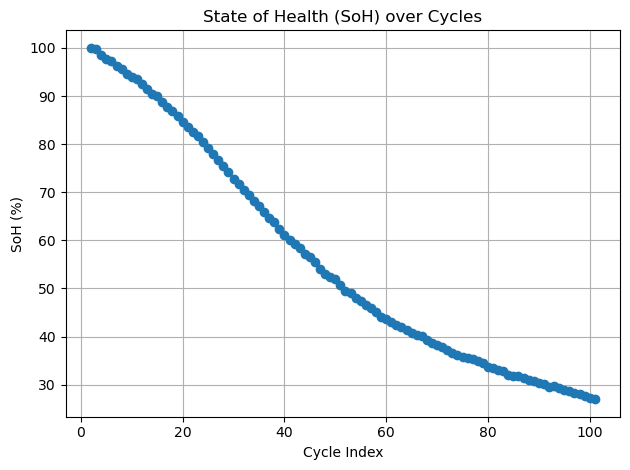

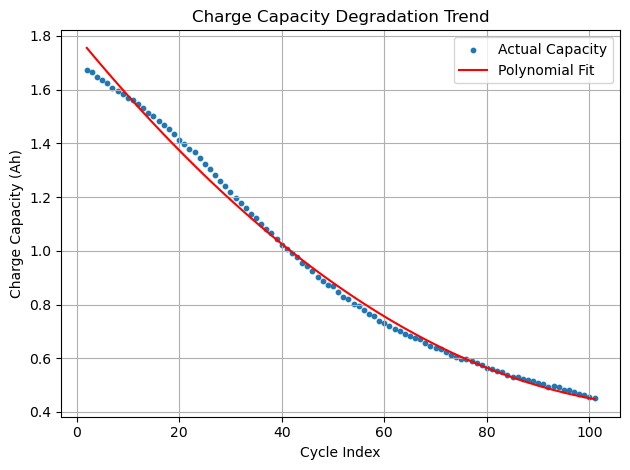

In [135]:
from numpy.polynomial import Polynomial


soh_df = charge_summary_rr.copy()
initial_capacity = soh_df[soh_df['Cycle_Index'] <= 3]['Charge_Capacity_RR'].max()
soh_df['SoH (%)'] = soh_df['Charge_Capacity_RR'] / initial_capacity * 100


plt.figure()
plt.plot(soh_df['Cycle_Index'], soh_df['SoH (%)'], marker='o')
plt.title('State of Health (SoH) over Cycles')
plt.xlabel('Cycle Index')
plt.ylabel('SoH (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


x = charge_summary_rr['Cycle_Index']
y = charge_summary_rr['Charge_Capacity_RR']


poly_model = Polynomial.fit(x, y, deg=2)
y_pred = poly_model(x)


plt.figure()
plt.scatter(x, y, s=10, label='Actual Capacity')
plt.plot(x, y_pred, color='red', label='Polynomial Fit')
plt.title('Charge Capacity Degradation Trend')
plt.xlabel('Cycle Index')
plt.ylabel('Charge Capacity (Ah)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
